<a href="https://colab.research.google.com/github/KristineYW/DS-Unit-2-Kaggle-Challenge/blob/master/Kristine_Wang_LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Do train/validate/test split with the Tanzania Waterpumps data.


In [4]:
# Import splitting class from sklearn

from sklearn.model_selection import train_test_split

# Split the training data into training and validation dfs
train, val = train_test_split(train, train_size=0.8, test_size=0.2, 
                              stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

####  Begin with baselines for classification.


In [5]:
# Check value counts for our target feature to see what the majority class is 
# Our majority class is 'functional' with a 54% frequency 

train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

####  Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.


In [6]:
# Check for duplicate features 
# Keep waterpoint_type

train['waterpoint_type'].value_counts()

communal standpipe             22778
hand pump                      14015
other                           5138
communal standpipe multiple     4864
improved spring                  631
cattle trough                     89
dam                                5
Name: waterpoint_type, dtype: int64

In [7]:
train['waterpoint_type_group'].value_counts()

communal standpipe    27642
hand pump             14015
other                  5138
improved spring         631
cattle trough            89
dam                       5
Name: waterpoint_type_group, dtype: int64

In [8]:
# Keep 'source'

train['source'].value_counts()

spring                  13620
shallow well            13507
machine dbh              8813
river                    7685
rainwater harvesting     1859
hand dtw                  698
lake                      586
dam                       518
other                     175
unknown                    59
Name: source, dtype: int64

In [9]:
train['source_type'].value_counts()

spring                  13620
shallow well            13507
borehole                 9511
river/lake               8271
rainwater harvesting     1859
dam                       518
other                     234
Name: source_type, dtype: int64

In [10]:
# Keep 'payment'

train['payment'].value_counts()

never pay                20287
pay per bucket            7161
pay monthly               6644
unknown                   6532
pay when scheme fails     3093
pay annually              2938
other                      865
Name: payment, dtype: int64

In [11]:
train['payment_type'].value_counts()

never pay     20287
per bucket     7161
monthly        6644
unknown        6532
on failure     3093
annually       2938
other           865
Name: payment_type, dtype: int64

In [12]:
# Keep 'extraction type'

train['extraction_type_group'].value_counts()

gravity            21448
nira/tanira         6526
other               5193
submersible         4894
swn 80              2930
mono                2261
india mark ii       1928
afridev             1435
rope pump            353
other handpump       292
other motorpump       94
wind-powered          93
india mark iii        73
Name: extraction_type_group, dtype: int64

In [13]:
train['extraction_type'].value_counts()

gravity                      21448
nira/tanira                   6526
other                         5193
submersible                   3770
swn 80                        2930
mono                          2261
india mark ii                 1928
afridev                       1435
ksb                           1124
other - rope pump              353
other - swn 81                 184
windmill                        93
india mark iii                  73
cemo                            70
other - play pump               65
walimi                          42
climax                          24
other - mkulima/shinyanga        1
Name: extraction_type, dtype: int64

In [0]:
# Write a function to wrangle the data sets in the same way 

import numpy as np

def wrangle(X):

  # Prevent error message
  X = X.copy()

  # Treat near-zero values like zero 
  X['latitude'] = X['latitude'].replace(-2e-08,0)

  # Replace zero values with nulls so we can impute later
  cols_with_zeros = ['longitude', 'latitude']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0,np.nan)
  
  # Drop duplicate and near-duplicate entries
  X = X.drop(columns=['quantity_group', 'extraction_type_group', 'payment_type',
                      'source_type', 'waterpoint_type_group'])
  
  # Return wrangled dataframe
  return X


In [0]:
# Apply wrangling to all data sets

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [16]:
# Define target
target = 'status_group'

# Take target and id out of training set 
train_features = train.drop(columns=[target, 'id'])

# Extract numeric features 
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Find cardinality of categorical features 
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Pull out features where cardinality is less than 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine numeric and low cardinality features list 
features = numeric_features + categorical_features

# Check out features list
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type']


In [0]:
# Isolate all train and test datasets by features columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [0]:
# Use sklearn pipeline to encode, impute, scale, and perform logistic regression on data sets

#Import classes
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

# Create the pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(min_samples_leaf=12, random_state=42)
)

# Fit LR model on training data
pipeline.fit(X_train, y_train)

# Score LR model on val data
pipeline.score(X_val, y_val)

# Predict on test data
y_pred = pipeline.predict(X_test)

#### Get your validation accuracy score.


In [19]:
# Print accuracy score 
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.773063973063973


#### Get and plot your feature importances.


In [0]:
# Pull out the named steps of the decision tree classifier 
model = pipeline.named_steps['decisiontreeclassifier']


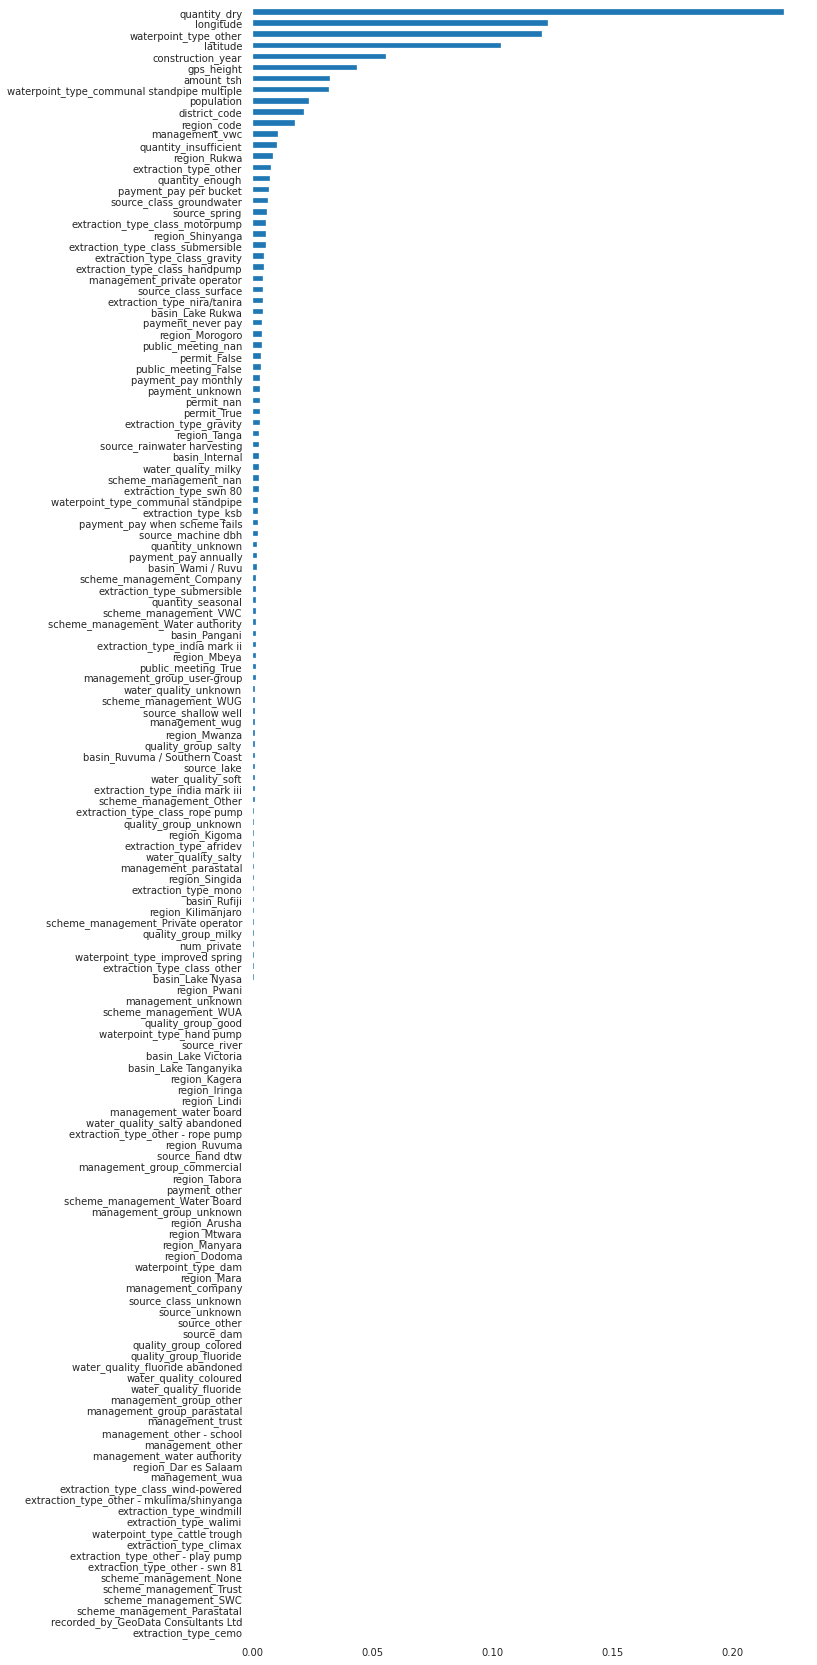

In [21]:
# Pull out the feature importances
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)

# Plot the feature importances 
import matplotlib.pyplot as plt
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

#### Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue Submit Predictions button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)


In [0]:
prediction = pd.DataFrame(y_pred, columns=['status_group']).to_csv('Kristine_submission.csv')


In [0]:
from google.colab import files
files.download('Kristine_submission.csv')

#### Commit your notebook to your fork of the GitHub repo.